In [4]:
import yfinance as yf
from auxillary import *
from indicators import *
from datetime import date
from processData import processData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import gc

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras import optimizers


In [5]:
prices, general, target, cluster, pc = processData("AAPL", 10)

## Initial attempt at model

In [6]:
variables = ["Close","OBV_ROC_Percentile", "MACD_ROC_Percentile"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], len(variables))))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=25,batch_size=32)

X_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))
result = model.evaluate(X_test)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)

real_stock_price = prices.iloc[-len(X_test):, 3:4].values

results = model.evaluate(X_test, y_sc.transform(real_stock_price))

Epoch 1/25
57/57 [==============================] - 26s 116ms/step - loss: 0.0052
Epoch 2/25
57/57 [==============================] - 6s 113ms/step - loss: 0.0013
Epoch 3/25
57/57 [==============================] - 7s 131ms/step - loss: 0.0012
Epoch 4/25
57/57 [==============================] - 7s 117ms/step - loss: 0.0011
Epoch 5/25
57/57 [==============================] - 6s 108ms/step - loss: 9.9872e-04
Epoch 6/25
57/57 [==============================] - 6s 107ms/step - loss: 0.0011
Epoch 7/25
57/57 [==============================] - 6s 112ms/step - loss: 8.7732e-04
Epoch 8/25
57/57 [==============================] - 6s 106ms/step - loss: 8.7764e-04
Epoch 9/25
57/57 [==============================] - 6s 106ms/step - loss: 9.3402e-04
Epoch 10/25
57/57 [==============================] - 6s 109ms/step - loss: 7.8621e-04
Epoch 11/25
57/57 [==============================] - 6s 107ms/step - loss: 9.6116e-04
Epoch 12/25
57/57 [==============================] - 6s 107ms/step - loss: 8.2894e

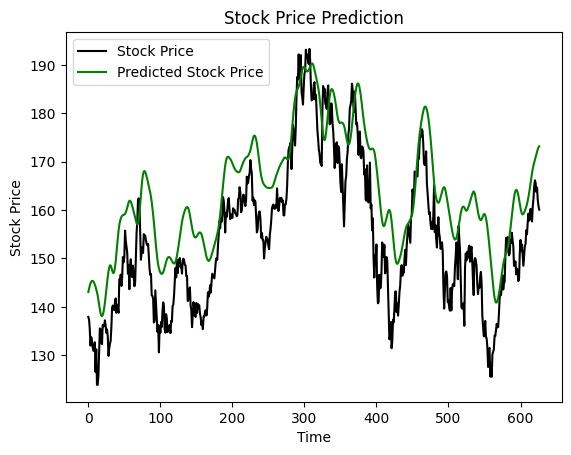

In [7]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
def buildRNN(num_layers, num_neurons, input_shape, lr):
    model = Sequential()
    model.add(LSTM(units=num_neurons,return_sequences=True,input_shape= input_shape))
    model.add(Dropout(0.2))
    
    i = 2
    while i <= num_layers:
            
        if i == num_layers:
            model.add(LSTM(units=50))
        else:
            model.add(LSTM(units=50,return_sequences=True))
        model.add(Dropout(0.2))
        i+=1

    model.add(Dense(units=1))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),loss='mean_squared_error')
    return model

## Split Data into 5 Folds for CV

In [9]:
variables = ["Close","OBV_ROC_Percentile", "MACD_ROC_Percentile"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)

train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

trainX, valX = cvSplit(X_train, 5)
trainY, valY = cvSplit(y_train, 5)


## Tune Number of LTSM layers using CV split

In [10]:
layers = []
layer_loss = []

for n_layers in range(2,7):
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(n_layers, 50, (X_train_.shape[1], len(variables)), 0.001)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)

        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / 5
    layers.append(n_layers)
    layer_loss.append(result_loss)


KeyboardInterrupt: 

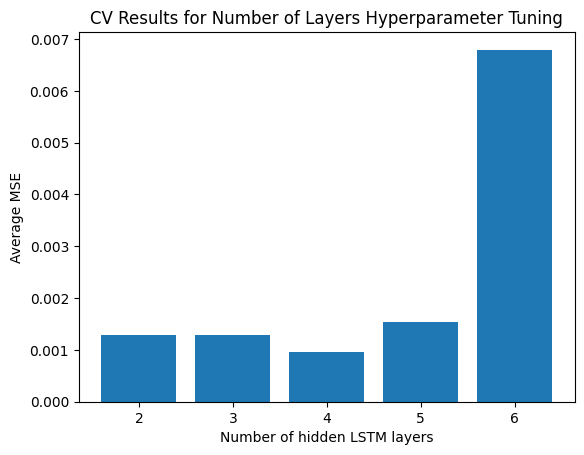

In [138]:
plt.bar(x = layers, height = layer_loss)
plt.title("CV Results for Number of Layers Hyperparameter Tuning")
plt.xlabel("Number of hidden LSTM layers")
plt.ylabel("Average MSE")
plt.show()

## Tune number of neurons

In [83]:
neurons = [10, 25, 50, 75, 100]
neurons_loss = []

for n_neurons in neurons:
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(4, n_neurons, (X_train_.shape[1], len(variables)), 0.001)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)   
        
        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / 5

    neurons_loss.append(result_loss)

Epoch 1/25
12/12 [==============================] - 20s 95ms/step - loss: 0.0027
Epoch 2/25
12/12 [==============================] - 1s 96ms/step - loss: 9.6282e-04
Epoch 3/25
12/12 [==============================] - 1s 96ms/step - loss: 7.3679e-04
Epoch 4/25
12/12 [==============================] - 1s 97ms/step - loss: 6.4127e-04
Epoch 5/25
12/12 [==============================] - 1s 95ms/step - loss: 6.7704e-04
Epoch 6/25
12/12 [==============================] - 1s 95ms/step - loss: 6.4381e-04
Epoch 7/25
12/12 [==============================] - 1s 96ms/step - loss: 6.1776e-04
Epoch 8/25
12/12 [==============================] - 1s 94ms/step - loss: 5.8455e-04
Epoch 9/25
12/12 [==============================] - 1s 96ms/step - loss: 6.0170e-04
Epoch 10/25
12/12 [==============================] - 1s 95ms/step - loss: 5.9489e-04
Epoch 11/25
12/12 [==============================] - 1s 94ms/step - loss: 5.6825e-04
Epoch 12/25
12/12 [==============================] - 1s 96ms/step - loss: 5.2

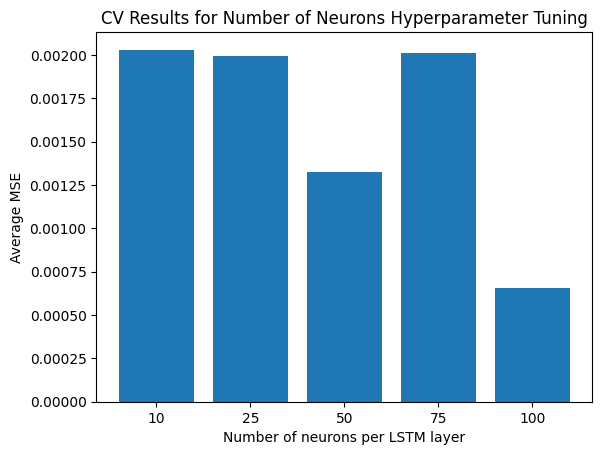

In [146]:
neurons_str = ["10", "25", '50', '75', '100']
plt.bar(x = neurons_str, height = neurons_loss)
plt.title("CV Results for Number of Neurons Hyperparameter Tuning")
plt.xlabel("Number of neurons per LSTM layer")
plt.ylabel("Average MSE")
plt.show()

## Tune Learning Rate Using CV 

In [87]:
from keras import optimizers

rates = [0.001, 0.005, 0.01, 0.05, 1]
rates_loss = []

for lr in rates:
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(4, 50, (X_train_.shape[1], len(variables)), lr)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)   
        
        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / len(trainX)

    rates_loss.append(result_loss)

Epoch 1/25


c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 16s 138ms/step - loss: 0.0011
Epoch 2/25
12/12 [==============================] - 2s 136ms/step - loss: 5.9176e-04
Epoch 3/25
12/12 [==============================] - 2s 141ms/step - loss: 4.5164e-04
Epoch 4/25
12/12 [==============================] - 2s 135ms/step - loss: 2.0185e-04
Epoch 5/25
12/12 [==============================] - 2s 139ms/step - loss: 1.2045e-04
Epoch 6/25
12/12 [==============================] - 2s 134ms/step - loss: 1.1376e-04
Epoch 7/25
12/12 [==============================] - 2s 136ms/step - loss: 1.1696e-04
Epoch 8/25
12/12 [==============================] - 2s 138ms/step - loss: 9.6347e-05
Epoch 9/25
12/12 [==============================] - 2s 183ms/step - loss: 7.6892e-05
Epoch 10/25
12/12 [==============================] - 4s 305ms/step - loss: 9.5017e-05
Epoch 11/25
12/12 [==============================] - 3s 273ms/step - loss: 8.5886e-05
Epoch 12/25
12/12 [==============================] - 4s 325ms/step - loss: 9.

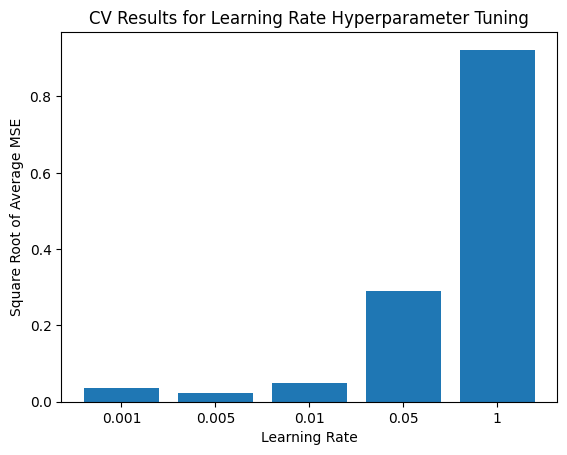

In [151]:
rates_str = ["0.001", "0.005", '0.01', '0.05', '1']
plt.bar(x = rates_str, height = np.sqrt(rates_loss))
plt.title("CV Results for Learning Rate Hyperparameter Tuning")
plt.xlabel("Learning Rate")
plt.ylabel("Square Root of Average MSE")
plt.show()
# 0.005 minimizes loss

Tuned parameters are: Learning rate - 0.005, LSTM layers - 4, Neurons per layer - 100

## Final Model Training

In [11]:
# Vanilla model

variables = ["Close"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = buildRNN(4, 100, (X_train.shape[1], len(variables)), 0.005)

model.fit(X_train,y_train,epochs=25,batch_size=32)

real_stock_price = prices.iloc[int(0.75*len(prices)):, 3:4].values

X_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))
result = model.evaluate(X_test)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)


Epoch 1/25
58/58 [==============================] - 21s 123ms/step - loss: 0.0040
Epoch 2/25
58/58 [==============================] - 7s 121ms/step - loss: 8.5057e-04
Epoch 3/25
58/58 [==============================] - 7s 125ms/step - loss: 9.2808e-04
Epoch 4/25
58/58 [==============================] - 7s 125ms/step - loss: 7.7145e-04
Epoch 5/25
58/58 [==============================] - 7s 120ms/step - loss: 9.4470e-04
Epoch 6/25
58/58 [==============================] - 7s 125ms/step - loss: 0.0011
Epoch 7/25
58/58 [==============================] - 7s 120ms/step - loss: 6.5399e-04
Epoch 8/25
58/58 [==============================] - 7s 124ms/step - loss: 5.3868e-04
Epoch 9/25
58/58 [==============================] - 7s 123ms/step - loss: 6.0105e-04
Epoch 10/25
58/58 [==============================] - 7s 128ms/step - loss: 7.6024e-04
Epoch 11/25
58/58 [==============================] - 8s 132ms/step - loss: 5.9818e-04
Epoch 12/25
58/58 [==============================] - 7s 122ms/step - l

In [15]:
results = model.evaluate(X_test, y_sc.transform(real_stock_price))
print(results)

20/20 [==============================] - 1s 67ms/step - loss: 0.0082
0.008213812485337257


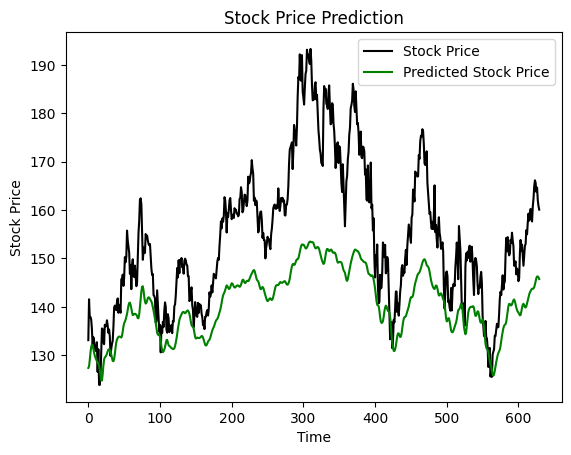

In [16]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Add first two principal components to vanilla model

In [17]:
variables = ["Close", "PC0", "PC1"]
training_set = pd.concat([prices, general, pc], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = buildRNN(4,100, (X_train.shape[1], len(variables)), 0.005)

model.fit(X_train,y_train,epochs=25,batch_size=32)

X_test = []
y_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
    y_test.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))

real_stock_price = prices.iloc[-len(X_test):, 3:4].values

predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)


Epoch 1/25
56/56 [==============================] - 27s 179ms/step - loss: 0.0044
Epoch 2/25
56/56 [==============================] - 10s 174ms/step - loss: 0.0013
Epoch 3/25
56/56 [==============================] - 11s 204ms/step - loss: 0.0011
Epoch 4/25
56/56 [==============================] - 10s 172ms/step - loss: 7.9894e-04
Epoch 5/25
56/56 [==============================] - 8s 136ms/step - loss: 7.9325e-04
Epoch 6/25
56/56 [==============================] - 8s 135ms/step - loss: 7.7309e-04
Epoch 7/25
56/56 [==============================] - 8s 140ms/step - loss: 6.6716e-04
Epoch 8/25
56/56 [==============================] - 7s 126ms/step - loss: 6.1427e-04
Epoch 9/25
56/56 [==============================] - 7s 127ms/step - loss: 0.0011
Epoch 10/25
56/56 [==============================] - 7s 127ms/step - loss: 6.6941e-04
Epoch 11/25
56/56 [==============================] - 8s 138ms/step - loss: 6.6528e-04
Epoch 12/25
56/56 [==============================] - 8s 133ms/step - loss: 

IndexError: index 2463 is out of bounds for axis 0 with size 2463

In [19]:
results = model.evaluate(X_test, y_sc.transform(real_stock_price))
print(results)

20/20 [==============================] - 5s 53ms/step - loss: 0.0077
0.007684787269681692


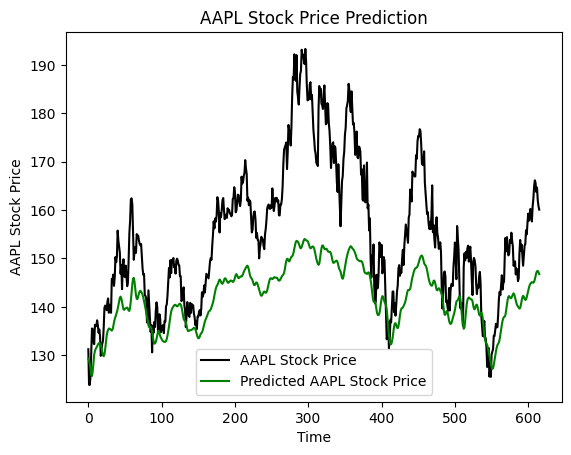

In [20]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Test on a different stock


In [21]:
prices, general, target, cluster, pc = processData("MMM", 10)
variables = ["Close", "PC0", "PC1"]
training_set = pd.concat([prices, general, pc], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = buildRNN(4,100, (X_train.shape[1], len(variables)), 0.005)

model.fit(X_train,y_train,epochs=25,batch_size=32)

X_test = []
y_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
    y_test.append(training_set_scaled[i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))

real_stock_price = prices.iloc[-len(X_test):, 3:4].values

predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)

Epoch 1/25
56/56 [==============================] - 31s 160ms/step - loss: 0.0390
Epoch 2/25
56/56 [==============================] - 8s 139ms/step - loss: 0.0054
Epoch 3/25
56/56 [==============================] - 8s 136ms/step - loss: 0.0051
Epoch 4/25
56/56 [==============================] - 8s 133ms/step - loss: 0.0037
Epoch 5/25
56/56 [==============================] - 8s 138ms/step - loss: 0.0032
Epoch 6/25
56/56 [==============================] - 8s 140ms/step - loss: 0.0030
Epoch 7/25
56/56 [==============================] - 8s 134ms/step - loss: 0.0033
Epoch 8/25
56/56 [==============================] - 8s 134ms/step - loss: 0.0030
Epoch 9/25
56/56 [==============================] - 8s 140ms/step - loss: 0.0029
Epoch 10/25
56/56 [==============================] - 8s 136ms/step - loss: 0.0022
Epoch 11/25
56/56 [==============================] - 8s 149ms/step - loss: 0.0021
Epoch 12/25
56/56 [==============================] - 8s 135ms/step - loss: 0.0021
Epoch 13/25
56/56 [=====

In [22]:
results = model.evaluate(X_test, y_sc.transform(real_stock_price))
print(results)

20/20 [==============================] - 6s 58ms/step - loss: 6.0210e-04
0.0006021013832651079


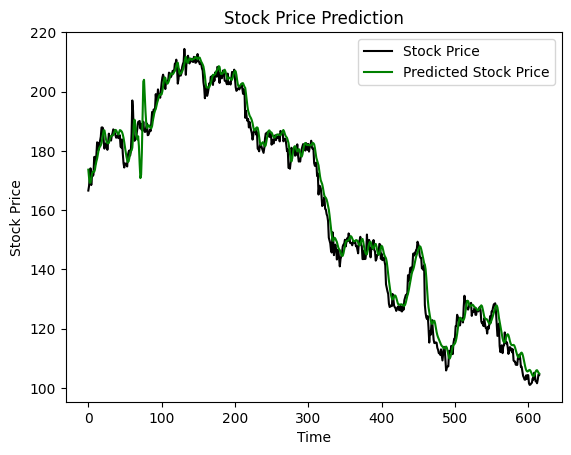

In [23]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Interactive program to pick what stock to predict

In [29]:
stocks = []
print("Enter the ticker symbols of interest (enter spacebar to exit)")
s = "  "
while s != " ":
    s = input("Ticker: ")
    if s == " " and len(stocks) == 0:
        print("Please enter a ticker symbol")
        s = "  "
        continue
    elif s == " ":
        break
    if s.upper() not in stocks:
        stocks.append(s.upper())

predicted_prices = []

for x in stocks:
    prices, general, target, cluster, pc = processData(x, 10)
    variables = ["Close", "PC0", "PC1"]
    training_set = pd.concat([prices, general, pc], axis = 1).loc[:,variables].dropna().values
    train_y = [row[0] for row in training_set]
    train_y = np.array(train_y).reshape(-1,1)

    x_sc = MinMaxScaler(feature_range=(0,1))
    y_sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = x_sc.fit_transform(training_set)
    train_y = y_sc.fit_transform(train_y)
    X_train = []
    y_train = []
    for i in range(60, int(len(training_set_scaled)*0.75)):
        X_train.append(training_set_scaled[i-60:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

    model = buildRNN(4,100, (X_train.shape[1], len(variables)), 0.005)

    model.fit(X_train,y_train,epochs=25,batch_size=32)

    X_test = []
    y_test = []
    for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
        X_test.append(training_set_scaled[i-60:i, :])
        y_test.append(training_set_scaled[i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))

    real_stock_price = prices.iloc[-len(X_test):, 3:4].values

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)

    today = pd.concat([prices["Close"], pc.loc[:, ["PC0", "PC1"]]], axis = 1).iloc[-60:].values
    today_scaled = x_sc.transform(today)

    predicted_price = model.predict(np.array([today_scaled]))
    predicted_price = y_sc.inverse_transform(predicted_price)

    predicted_prices.append(predicted_price[0])
    
    

Enter the ticker symbols of interest (enter spacebar to exit)
Epoch 1/25
56/56 [==============================] - 30s 178ms/step - loss: 0.0159
Epoch 2/25
56/56 [==============================] - 10s 186ms/step - loss: 0.0056
Epoch 3/25
56/56 [==============================] - 11s 190ms/step - loss: 0.0044
Epoch 4/25
56/56 [==============================] - 10s 184ms/step - loss: 0.0039
Epoch 5/25
56/56 [==============================] - 10s 174ms/step - loss: 0.0037
Epoch 6/25
56/56 [==============================] - 9s 169ms/step - loss: 0.0032
Epoch 7/25
56/56 [==============================] - 10s 171ms/step - loss: 0.0029
Epoch 8/25
56/56 [==============================] - 9s 166ms/step - loss: 0.0025
Epoch 9/25
56/56 [==============================] - 10s 179ms/step - loss: 0.0024
Epoch 10/25
56/56 [==============================] - 10s 184ms/step - loss: 0.0026
Epoch 11/25
56/56 [==============================] - 11s 203ms/step - loss: 0.0024
Epoch 12/25
56/56 [=================

In [32]:
for i in range(len(stocks)):
    text = "Predicted price for " + stocks[i] + ": $" + str(predicted_prices[i][0])
    print(text)

Predicted price for ENB.TO: $51.863052
Predicted price for BNS.TO: $67.551384
